In [1]:
#importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()

#read file
data = pd.read_csv('train.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Exploratory Data Analysis(EDA)

The first step is to take an overview of our data in order to think about the better way to approach the probelm


In [2]:
#insight of data disposal
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
#Amount of Tweets in each label
print(len(data[data.label == 0]), 'Regular Tweets')
print(len(data[data.label == 1]), 'Hatred Tweets')

29720 Regular Tweets
2242 Hatred Tweets


In [4]:
#spliting the hashtags in order to use them in further analysis

hashtags = data['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
data.loc[:, 'hashtags'] = hashtags['hashtag']
data['hashtags'].fillna('', inplace=True)

data.loc[:, 'mentions'] = data['tweet'].str.count('@[a-zA-Z0-9_]+')

data.head()

,id,label,tweet,hashtags,mentions
0,1,0,@user when a father is dysfunctional and is s...,run,1
1,2,0,@user @user thanks for #lyft credit i can't us...,lyft disapointed getthanked,2
2,3,0,bihday your majesty,,0
3,4,0,#model i love u take with u all the time in ...,model,0
4,5,0,factsguide: society now #motivation,motivation,0


In [5]:
cont_mentions=0

for i in data['mentions']:
    if(i>0):
        cont_mentions+=1

cont_hash=0;
        
for i in data['hashtags']:
    if(len(i)>0):
        cont_hash+=1
        
print("Number of Tweets with '@'",cont_mentions);
print("Number of Tweets with '#'",cont_hash);

Number of Tweets with '@' 11126
Number of Tweets with '#' 23421


# Pre Processing the Data

Let's remove some useless data and split useful data from our train set.

We may classify numbers,punctuation and mentions under the tag of not useful data, and therefore remove them from the text we want to process. Lets also split our data in a shape that will shorten our code in the next lines.

In [6]:
#Now lets replace all numbers, mentions and hashtags in order to clean our text
data.tweet = data.tweet.str.replace('@[a-zA-Z0-9_]+', '')
data.tweet = data.tweet.str.replace('#[a-zA-Z0-9_]+', '')
data.tweet = data.tweet.str.replace('[^a-zA-Z]', ' ')


data.head()

,id,label,tweet,hashtags,mentions
0,1,0,when a father is dysfunctional and is so sel...,run,1
1,2,0,thanks for credit i can t use cause they do...,lyft disapointed getthanked,2
2,3,0,bihday your majesty,,0
3,4,0,i love u take with u all the time in ur ...,model,0
4,5,0,factsguide society now,motivation,0


In [7]:
#Now we will remove words that don't carry much significance(stopwords)
#send all caracters to lower case and lemmatize words
def pre_process(tweet):
    tweets = tweet.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if not word in set(stopwords.words('english'))]
    tweets = [lemma.lemmatize(word) for word in tweets]
    return tweets


data['words_to_analyze']=data.tweet.apply(pre_process)

In [8]:
#let's also organize our hashtags
def hash_procces(tweets):
    tweets = tweets.lower()
    tweets= tweets.split()
    tweets = [lemma.lemmatize(word) for word in tweets]
    return tweets

data['hash_to_analyze']=data.hashtags.apply(hash_procces)
data.head()

,id,label,tweet,hashtags,mentions,words_to_analyze,hash_to_analyze
0,1,0,when a father is dysfunctional and is so sel...,run,1,"[father, dysfunctional, selfish, drag, kid, dy...",[run]
1,2,0,thanks for credit i can t use cause they do...,lyft disapointed getthanked,2,"[thanks, credit, use, cause, offer, wheelchair...","[lyft, disapointed, getthanked]"
2,3,0,bihday your majesty,,0,"[bihday, majesty]",[]
3,4,0,i love u take with u all the time in ur ...,model,0,"[love, u, take, u, time, ur]",[model]
4,5,0,factsguide society now,motivation,0,"[factsguide, society]",[motivation]


## Now lets use the wordcloud to turn visual the most common words in each of our blocks

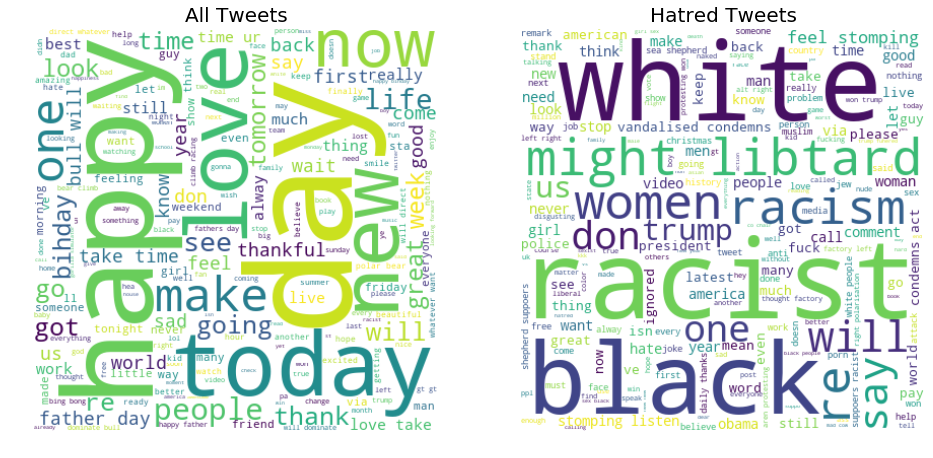

In [9]:
from wordcloud import WordCloud, STOPWORDS
stopwords = STOPWORDS.add('amp')

all_words = ' '.join(data.tweet.values)
hatred_words = ' '.join(data[data.label == 1].tweet.values)

plt.figure(figsize=(16, 8))

cloud1 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(all_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('All Tweets', size=20)

cloud2 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Hatred Tweets', size=20)
plt.show()

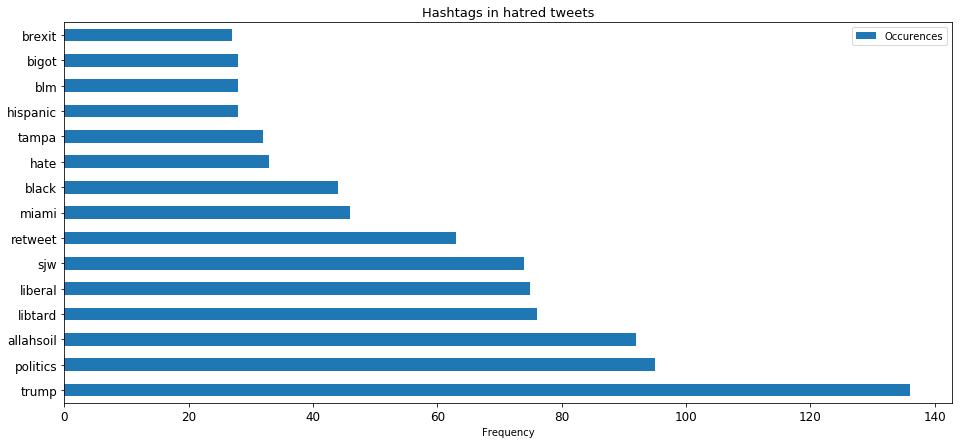

In [10]:
#Frequency Histogram of the main hashtags in hatred tweets
from nltk import FreqDist
hatred_hashtags = FreqDist(list(' '.join(data[data.label==1].hashtags.values).split())).most_common(15)

plt.rcParams['figure.figsize'] = (35,7)

ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Occurences']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('Frequency')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.show()

We will than use "words_to_analyze" and "hash_to_analyze" columns in order to classify our data.

Since bayes critery is normaly defined for a single event probability, we will use our hashtag column as a new value to the evaluation, it will be explained in details later. 

Since Dice Coefficient has empirically proven itself to be useful under heterogeneous data, ande we have a poor distribuition over our 2 labels (label[0] >> label[1]) we may use it as our result metric

# Using Naive Bayes Algorithm to train and classify the tweets 

Two main reasons have been considered in order to decide using this algorithm:

* It's commonly used to tag, spam e-mails, which is an analogue problem tou ours; 

* Since it's math is relatively simple,which allows easy modifications in its terms, and itś results are often accurate, this method can generate really precise results;

Lets make two assumptions, so we can work with the algorithm

1. The order of the words in document X makes no difference but repetitions of words do.

2. Words appear independently of each other, given the document class.

If we assume that both conditions above are true we can decide de label of a tweet, by comparing it's score to hatred, and non-hatred, the bigger score decides de label.

$$
    score(y,w_1,\dots,w_n)= \frac{L_{freq}}{T_{words}} + \sum_{i=1}^n \frac{W_{freq}}{L_{freq}}
$$

where:  
$L_{freq}$-> Total of Words labeled $y_i$;  
$T_{words}$-> Total of Words in the samples;    
$W_{freq}$-> Number of occurences of word $w_i$ in a label $y_i$  

Now we will make three changes to this equation

1. Since we may have lots of small numbers, we can logarithm both sides of the equation, and have a new score classification, that avoids underflow problem

2. We will also insert a pair of therms p and m intdo de equation to avoid having a discontinuity in our function, if we get a new word, that has never been seen before(This are called Dirichlet Coefficients)

3. And finally, for each time we find a text without a potentially hatred hashtag(we will use the 15 more frequent hashtags in this problem) we will slightly increase it's non-hatred(normal tweet) score.

So our new equation will have this shape:

$$
 score(y,w_1,\dots,w_n)= log\frac{L_{freq}}{T_{words}} + \sum_{i=1}^n log\frac{W_{freq}+mp}{L_{freq}+p}
$$

And at last, if we detect a tweet without hatred common hashtags, we increase it's normal score by:

$$
    \frac{k}{full_{sum}}
$$

where:  
$k$ -> a constant we try to figure out the best fitting value  
$full_{sum}$ -> sum of all events of hatred hashtags in the train set;

In [11]:
#training the model with de 22000 samples
word_frequency_label=[dict(),dict()]
words_per_label=[0,0]
total_words=0


for i in range(22000):
    for j in data['words_to_analyze'][i]:
        total_words+=1
        words_per_label[data['label'][i]]+=1
        
        if j not in word_frequency_label[data['label'][i]]:
            word_frequency_label[data['label'][i]][j]=0
        
        word_frequency_label[data['label'][i]][j]+=1
        

common_hatred_hashtags=dict()
full_sum=0

for i in hatred_hashtags:
    common_hatred_hashtags[i[0]]=i[1]
    full_sum+=i[1]

True Positive Results[Tweets successfully classified] 9249
False Negative[Hatred Tweets not Classified] 385
False Positive[Normal Tweets Classfied] 328


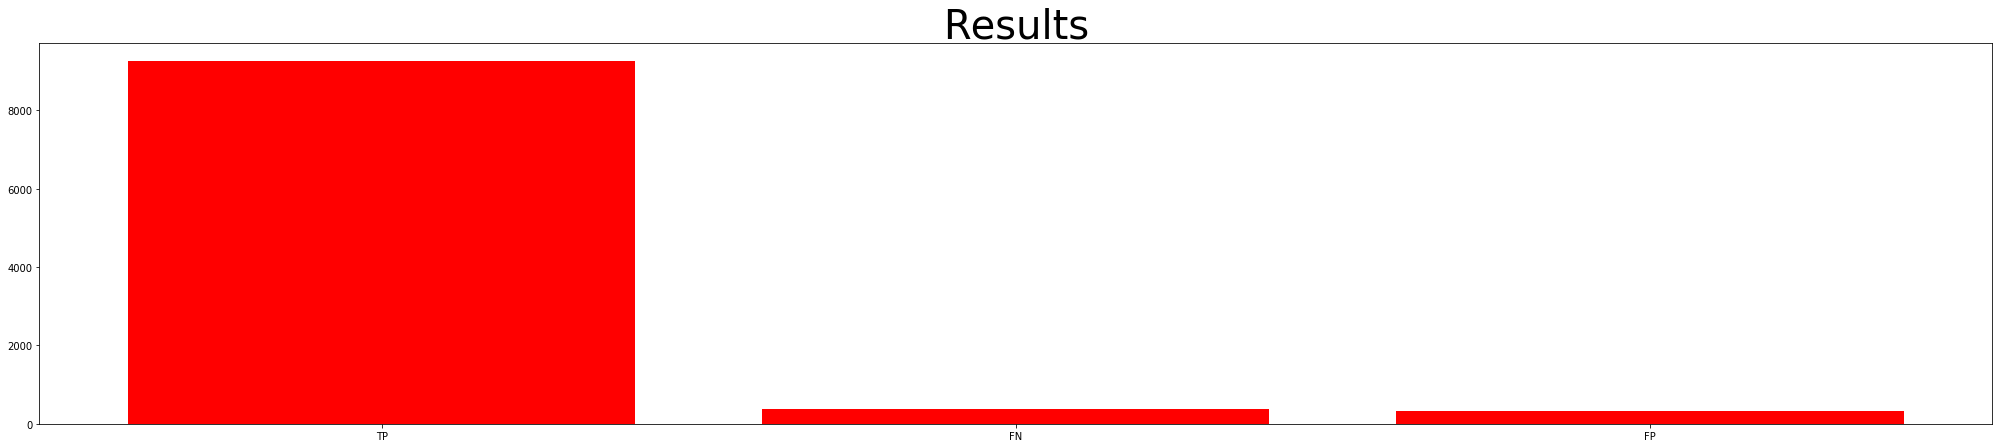

713


In [12]:
#Now with the trainde model we can try to tag the last tweets and see our performance
from math import log

#Dirichlet Coefficients(Defined by trial and error)
m=0.001
p=0.05

#Hashtags adjustment Coefficent
k=1.8

#Acceptance taxes
right_guess=0 # True Positive (TP)
wrong_guess=0 # False Negative(FN) 
wrong_guess2=0 # False Postitive(FP)

for i in range (22000,31962):
    score_for_normal=log(words_per_label[0]/total_words,10)
    score_for_hatred=log(words_per_label[1]/total_words,10)

    for j in data['words_to_analyze'][i]:
        if j in word_frequency_label[0]:
            score_for_normal+=log((word_frequency_label[0][j]+m*p)/(words_per_label[0]+m),10)
        else: 
            score_for_normal+=log((m*p)/(words_per_label[0]+m),10)
            
        if j in word_frequency_label[1]:
            score_for_hatred+=log((word_frequency_label[1][j]+m*p)/(words_per_label[1]+m),10)
        else: 
            score_for_hatred+=log((m*p)/(words_per_label[1]+m),10)
            
        #Adding the hashtags terms to modify our scores
        for j in data['hash_to_analyze'][i]:
            if j not in hatred_hashtags:
                score_for_normal+=k/full_sum
    
    if score_for_hatred > score_for_normal and data['label'][i] == 1:
        right_guess+=1
    elif score_for_hatred <= score_for_normal and data['label'][i] == 0:
        right_guess+=1
    elif score_for_hatred < score_for_normal and data['label'][i] == 1:
        wrong_guess+=1
    else:
        wrong_guess2+=1
        
print("True Positive Results[Tweets successfully classified]",right_guess)
print("False Negative[Hatred Tweets not Classified]",wrong_guess)
print("False Positive[Normal Tweets Classfied]",wrong_guess2)

xres=['TP','FN','FP']
yres=[right_guess,wrong_guess,wrong_guess2]

plt.bar(xres,yres,color='red')

plt.xticks(xres)
plt.title('Results',size=40)

plt.xlabel=('Type of Error')
plt.ylabel=('Occurrences')

plt.show()

print(wrong_guess+wrong_guess2)

Using the numbers we have above, and knowing that our data has boolean atribuition, dice coefficient can be calculated by the following equation:

$$
    DSC=\frac{2TP}{2TP+FP+FN}
$$

In [13]:
#Dice Coefficient Final Evaluation
total_wrong_data=wrong_guess+wrong_guess2
print("Dice Coefficient Evaluation:",2*right_guess/(2*right_guess+total_wrong_data))

Dice Coefficient Evaluation: 0.9628858466503566


So in the end of process we obtained an extremly high dice coefficient, even without using all of our train set data, to train our model, what is really impressive.